In [43]:
import random
import matplotlib.pyplot as plt
import spacy
import csv
import gzip
import tqdm
import pandas as pd
from pyserini.search import SimpleSearcher
from collections import defaultdict

In [4]:
nlp = spacy.load('en_core_web_sm')
searcher = SimpleSearcher('indexes/lucene-index-msmarco-doc')

In [5]:
# In the corpus tsv, each docid occurs at offset docoffset[docid]
docoffset = {}
with gzip.open("train/msmarco-docs-lookup.tsv.gz", 'rt', encoding='utf8') as f:
    tsvreader = csv.reader(f, delimiter="\t")
    for [docid, _, offset] in tsvreader:
        docoffset[docid] = int(offset)


def getcontent(docid, f):
    """getcontent(docid, f) will get content for a given docid (a string) from filehandle f.
    The content has four tab-separated strings: docid, url, title, body.
    """

    f.seek(docoffset[docid])
    line = f.readline()
    assert line.startswith(docid + "\t"), f"Looking for {docid}, found {line}"
    return line.rstrip()

In [63]:
querystring = {}
with open("dev/queries.docdev.tsv", encoding='utf8') as f:
    tsvreader = csv.reader(f, delimiter="\t")
    for [topicid, querystring_of_topicid] in tsvreader:
        querystring[topicid] = querystring_of_topicid

In [7]:
query_with_metrics = defaultdict(dict)
with open('results_dev_100') as f:
    results = f.readlines()
    for line in results:
        x, y, z = line.split()
        query_with_metrics[y][x] = float(z)

In [8]:
queries_sorted_by_mrr = sorted([x for x in query_with_metrics if query_with_metrics[x]['recip_rank'] > 0], key=lambda x: query_with_metrics[x]['recip_rank'])
print(len(queries_sorted_by_mrr))
next((i, x) for i, x in enumerate(queries_sorted_by_mrr) if query_with_metrics[x]['recip_rank'] == 1)

4195


(3357, '1000017')

[0.1429, 0.013, 0.0333, 0.0769, 0.0625, 0.2, 0.0526, 0.1429, 0.0141, 0.037, 0.0164, 0.0115, 0.0185, 0.25, 0.1, 0.0182, 0.0385, 0.25, 0.2, 0.0526, 0.0123, 0.0227, 0.1429, 0.0125, 0.2, 0.0227, 0.1429, 0.2, 0.2, 0.1667, 0.25, 0.0833, 0.0417, 0.0417, 0.0179, 0.0417, 0.25, 0.0192, 0.04, 0.1429, 0.2, 0.2, 0.1429, 0.0435, 0.0909, 0.0385, 0.0526, 0.0357, 0.1429, 0.0667, 0.3333, 0.3333, 0.5, 0.3333, 0.3333, 0.5, 0.277, 0.5, 0.5, 0.5, 0.5, 0.3333, 0.5, 0.5, 0.3333, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3333, 0.25, 0.3333, 0.5, 0.3333, 0.5, 0.3333, 0.5, 0.3333, 0.3333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


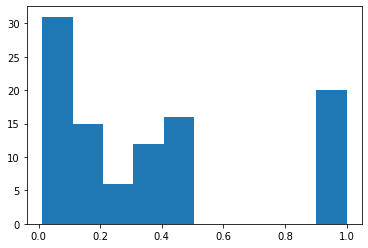

In [9]:
selected_queries = random.sample(queries_sorted_by_mrr[:2500], 50) + random.sample(queries_sorted_by_mrr[2500:3357], 30) + random.sample(queries_sorted_by_mrr[3357:], 20)
print([query_with_metrics[x]['recip_rank'] for x in selected_queries])
plt.clf()
plt.hist([query_with_metrics[x]['recip_rank'] for x in selected_queries], bins=10)
plt.show()

In [67]:
queries_to_docs = defaultdict(list)
queries_to_score = defaultdict(dict)
docs_to_text = {}
with open('results/test-bm25-100.trec') as f:
    lines = f.readlines()
    for line in tqdm.tqdm(lines):
        query_id, _, doc_id, rank, score, _ = line.split()
        if query_id in selected_queries:
            queries_to_docs[query_id].append(doc_id)
            queries_to_score[query_id][doc_id] = float(score)
            docs_to_text[doc_id] = searcher.doc(doc_id).contents().replace('\n', ' ')

100%|██████████| 20000/20000 [00:03<00:00, 5079.50it/s]


In [68]:
query_with_metrics['1005586']

{'map': 0.5,
 'recip_rank': 0.5,
 'recall_100': 1.0,
 'ndcg_cut_10': 0.6309,
 'ndcg_cut_100': 0.6309}

In [60]:
bert_res = pd.read_csv('results_eval_set_bert.tsv', sep='\t', header=None)
queries_to_bert_score = defaultdict(dict)
for _, (q_id, doc_id, score) in bert_res.iterrows():
    queries_to_bert_score[str(q_id)][doc_id] = score

In [61]:
queries_to_docs = defaultdict(list)
queries_to_score = defaultdict(dict)
docs_to_text = {}
with open('results/dev-bm25-100.trec') as f:
    lines = f.readlines()
    for line in tqdm.tqdm(lines):
        query_id, _, doc_id, rank, score, _ = line.split()
        if query_id in queries_to_bert_score:
            queries_to_docs[query_id].append(doc_id)
            queries_to_score[query_id][doc_id] = float(score)
            docs_to_text[doc_id] = searcher.doc(doc_id).contents().replace('\n', ' ')

100%|██████████| 519300/519300 [00:02<00:00, 225718.32it/s]


In [73]:
improved_metrics = defaultdict(dict)
with open('rerank_results/rerank_per_query') as f:
    results = f.readlines()
    for line in results:
        x, y, z = line.split()
        improved_metrics[y][x] = float(z)

{'map': 0.25,
 'recip_rank': 0.25,
 'recall_100': 1.0,
 'ndcg_cut_10': 0.4307,
 'ndcg_cut_100': 0.4307}

In [75]:
improved_queries = [query for query in improved_metrics if improved_metrics[query]['recip_rank'] > query_with_metrics[query]['recip_rank']]
len(improved_queries)

47

In [76]:
worsened_queries = [query for query in improved_metrics if improved_metrics[query]['recip_rank'] < query_with_metrics[query]['recip_rank']]
len(worsened_queries)

17

In [81]:
query_performance = sorted([(improved_metrics[query]['recip_rank'] - query_with_metrics[query]['recip_rank'], query) for query in improved_metrics])
query_performance

[(-0.5, '1098804'),
 (-0.3571, '540906'),
 (-0.25, '65583'),
 (-0.23329999999999998, '342115'),
 (-0.1375, '823549'),
 (-0.1, '1066116'),
 (-0.08329999999999999, '1097448'),
 (-0.08329999999999999, '194724'),
 (-0.059699999999999996, '971213'),
 (-0.04999999999999999, '493508'),
 (-0.033300000000000024, '1089414'),
 (-0.028399999999999995, '1000319'),
 (-0.008300000000000002, '202797'),
 (-0.0069, '675320'),
 (-0.004299999999999998, '274981'),
 (-0.0026, '95409'),
 (-0.0023, '963788'),
 (0.0, '1005586'),
 (0.0, '1006911'),
 (0.0, '1083017'),
 (0.0, '1084326'),
 (0.0, '1084755'),
 (0.0, '1089002'),
 (0.0, '1089143'),
 (0.0, '1092257'),
 (0.0, '1095335'),
 (0.0, '1095357'),
 (0.0, '1101739'),
 (0.0, '147073'),
 (0.0, '160255'),
 (0.0, '212977'),
 (0.0, '25344'),
 (0.0, '306105'),
 (0.0, '31432'),
 (0.0, '34039'),
 (0.0, '414276'),
 (0.0, '433220'),
 (0.0, '455273'),
 (0.0, '46579'),
 (0.0, '497536'),
 (0.0, '506579'),
 (0.0, '527568'),
 (0.0, '543951'),
 (0.0, '57614'),
 (0.0, '631724'),